# Importando librerías y funciones

In [1]:
#Librería de graficación
import matplotlib.pyplot as plt
import matplotlib as mp
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import metpy.calc as mpcalc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gsa
import matplotlib.ticker as mticker
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot, transforms
import matplotlib.colors as colors
from shapely.geometry.polygon import LinearRing

#Librerías para red neuronal


#Librerías de procesamiento matemático y lectura de archivos
import numpy as np
import netCDF4 as nc
import pandas as pd
import glob
import os
from scipy import signal

#Librería de estadística
import scipy as sp
from scipy.stats import pearsonr,spearmanr

#librería para manejo de fechas
from datetime import datetime,timedelta

plt.style.use("seaborn")
mp.rcParams['xtick.labelsize']=15
mp.rcParams['ytick.labelsize']=15

mp.rcParams['axes.labelsize']=17

In [2]:
def reading_netcdf(ruta):
    data=nc.Dataset(ruta)
    for i in data.variables:
        try:
            print (i,data.variables[i].shape,data.variables[i].units) 
        except:
            print (i,data.variables[i].shape) 
    print("\n")
    data_variables=[np.array(data[i][:]) for i in list(data.variables.keys())]
    return data_variables

Función para obtener realizar un análisis espectral

In [3]:
def T_fourier(serie):
    fourier=np.fft.fft(serie)
    freq= np.fft.fftfreq(len(serie)) 
    pot = np.abs(fourier*1/len(serie))**2
    periodos = 1/freq
    freq_pos=np.where(freq>=0)[0]
    
    return fourier,freq_pos,pot,periodos,freq

# Cargando los datos

In [4]:
rutas = np.array(np.sort(glob.glob("/home/franklin/Documentos/GitHub/TDG/Dataset/Glorys_CMEMS_Monthly/*.nc")),dtype="str")

#Al estar por años se debe concatenar
for i in range(0,len(rutas)):
    if i==0:
        [d,lat,v,temp,u,time,lon,ssh]=reading_netcdf(rutas[i])
    else:
        [d2,lat2,v2,temp2,u2,time2,lon2,ssh2]=reading_netcdf(rutas[i])
        ssh=np.concatenate((ssh,ssh2))
        temp=np.concatenate((temp,temp2))
        time=np.concatenate((time,time2))
        v=np.concatenate((v,v2))
        u=np.concatenate((u,u2))

depth (1,) m
latitude (241,) degrees_north
vo (12, 1, 241, 1873) m s-1
thetao (12, 1, 241, 1873) degrees_C
uo (12, 1, 241, 1873) m s-1
time (12,) hours since 1950-01-01
longitude (1873,) degrees_east
zos (12, 241, 1873) m


depth (1,) m
latitude (241,) degrees_north
vo (12, 1, 241, 1873) m s-1
thetao (12, 1, 241, 1873) degrees_C
uo (12, 1, 241, 1873) m s-1
time (12,) hours since 1950-01-01
longitude (1873,) degrees_east
zos (12, 241, 1873) m


depth (1,) m
latitude (241,) degrees_north
vo (12, 1, 241, 1873) m s-1
thetao (12, 1, 241, 1873) degrees_C
uo (12, 1, 241, 1873) m s-1
time (12,) hours since 1950-01-01
longitude (1873,) degrees_east
zos (12, 241, 1873) m


depth (1,) m
latitude (241,) degrees_north
vo (12, 1, 241, 1873) m s-1
thetao (12, 1, 241, 1873) degrees_C
uo (12, 1, 241, 1873) m s-1
time (12,) hours since 1950-01-01
longitude (1873,) degrees_east
zos (12, 241, 1873) m


depth (1,) m
latitude (241,) degrees_north
vo (12, 1, 241, 1873) m s-1
thetao (12, 1, 241, 1873) degrees

AttributeError: 'numpy.str_' object has no attribute 'variables'

In [5]:
print(nc.Dataset(rutas[0]))

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: Monthly mean fields for product GLOBAL_REANALYSIS_PHY_001_030
    references: http://marine.copernicus.eu
    credit: E.U. Copernicus Marine Service Information (CMEMS)
    licence: http://marine.copernicus.eu/services-portfolio/service-commitments-and-licence/
    contact: servicedesk.cmems@mercator-ocean.eu
    producer: CMEMS - Global Monitoring and Forecasting Centre
    institution: Mercator Ocean
    Conventions: CF-1.6
    area: GLOBAL
    product: GLOBAL_REANALYSIS_001_030
    dataset: global-reanalysis-001-030-monthly
    source: MERCATOR GLORYS12V1
    product_user_manual: http://marine.copernicus.eu/documents/PUM/CMEMS-GLO-PUM-001-030.pdf
    quality_information_document: http://marine.copernicus.eu/documents/QUID/CMEMS-GLO-QUID-001-030.pdf
    _CoordSysBuilder: ucar.nc2.dataset.conv.CF1Convention
    comment: 
    history: Data extracted from dataset http://localhost:

In [6]:
ssh[ssh<=-1000]=np.nan
da=[datetime(1950,1,1,0,0,0)+timedelta(hours=int(time[w])) for w in range (0,len(time))]
date=pd.DatetimeIndex(da)
new_array = np.array(date.to_pydatetime(), dtype=object)
ssh_copy=np.copy(ssh)
t=temp[:,0,:,:]
vel_u=u[:,0,:,:]
vel_v=v[:,0,:,:]

In [11]:
vel_u[vel_u<=-1000]=np.nan
vel_v[vel_v<=-1000]=np.nan

In [25]:
t[t<=-1000]=np.nan

# Definiendo la región y la serie temporal

A continuación se preparan las series de datos espacio-temporales a usar y se determina la serie temporal final que será evaluada a través de el análisis espectral

In [8]:
lat_max = 3.85
lat_min = 3.65
lon_max = -77.2
lon_min = -77.6

ind_lat = np.where((lat<=lat_max) & (lat>=lat_min))[0]
ind_lon = np.where((lon<=(360+lon_max)) & (lon>=(360+lon_min)))[0]

La serie temporal que se determinará para la región del océano pacífico colombiano será el promedio longitudinal y latitudinal de los datos obtenidos

In [9]:
x_tick_labels = [u'140\N{DEGREE SIGN}E', u'160\N{DEGREE SIGN}E',
                 u'180\N{DEGREE SIGN}', u'160\N{DEGREE SIGN}W',
                 u'140\N{DEGREE SIGN}W',u'120\N{DEGREE SIGN}W',u'100\N{DEGREE SIGN}W',u'80\N{DEGREE SIGN}W']

y_tick_labels = [u'-10\N{DEGREE SIGN}N', u'-5\N{DEGREE SIGN}N',
                 u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N',
                 u'10\N{DEGREE SIGN}N']

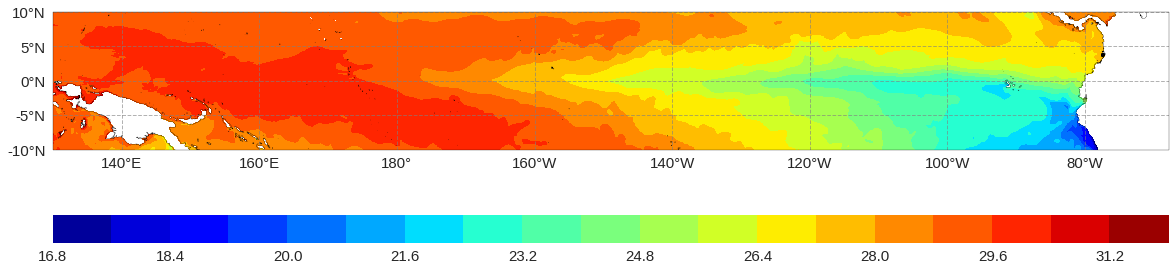

In [26]:
lns = [lon_max, lon_max, lon_min, lon_min]
lts = [lat_min, lat_max, lat_max,lat_min]
ring = LinearRing(list(zip(lns, lts)))

fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,t[10,:,:],20,transform=ccrs.PlateCarree(),cmap="jet")
# ct=ax.contour(x,y,ssh,20,transform=ccrs.PlateCarree(),colors='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=180), draw_labels=False,
                  ylocs=np.array([-10,-5,0,5,10]),xlocs=np.array(np.arange(-60,140,20)),linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.add_geometries([ring], ccrs.PlateCarree(), facecolor="None", edgecolor='black',linewidth=2)
ax.coastlines(resolution='10m')



ax.set_xticks(np.arange(-40, 120, 20))
ax.set_xticklabels(x_tick_labels)

ax.set_yticks(np.arange(-10, 11, 5))
ax.set_yticklabels(y_tick_labels)

# ax.set_xlim((102,103))
# ax.set_ylim((3.5,4))

cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

In [15]:
sla_lat=np.nanmean(ssh[:,ind_lat],axis=1)
serie_ssh=np.nanmean(sla_lat[:,ind_lon],axis=1)
serie_ssa=pd.Series(serie_ssh-np.mean(serie_ssh),index=date)

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'sla [m]')

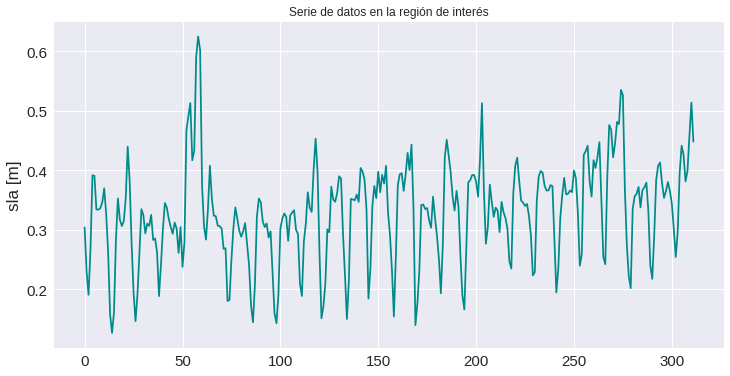

In [143]:
plt.figure(figsize=(12,6))
plt.title("Serie de datos en la región de interés")
plt.plot(serie_ssh,c="darkcyan")
plt.ylabel("sla [m]")
# plt.savefig(".\Graficas\Series.jpg",dpi=800,box_inches="tight",pad_inches=0)

# Realizando el análisis espectral

In [17]:
sla_fourier,sla_freq_pos,sla_potencias,sla_periodos,sla_freq,=T_fourier(serie_ssa.values)

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


# Graficando el espectro de potencias

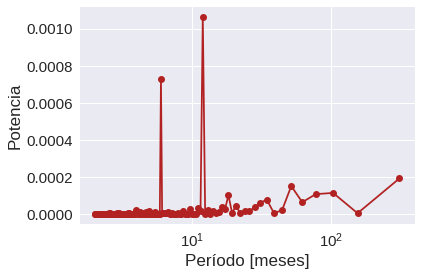

In [18]:
plt.figure()
plt.plot(sla_periodos[sla_freq_pos],sla_potencias[sla_freq_pos],'-o',c="firebrick")
plt.xscale("log")
plt.xlabel("Período [meses]")
plt.ylabel("Potencia")
plt.savefig(".\Graficas\Espectro de potencias.jpg",dpi=800,box_inches="tight",pad_inches=0)

# Seleccionando la banda de interés

In [19]:
freq_fil=np.copy(sla_fourier)
freq_fil[np.where((np.abs(1/sla_freq)<24) | (np.abs(1/sla_freq)>12*6))]=0

Pot_fil=np.abs(freq_fil*1/len(freq_fil))**2

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


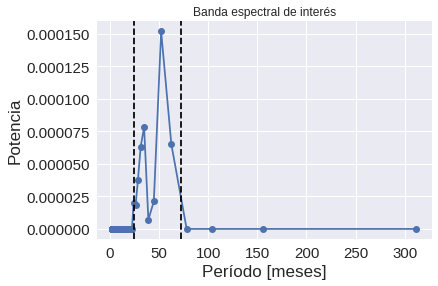

In [20]:
plt.figure()
plt.title("Banda espectral de interés")
plt.plot(sla_periodos[sla_freq_pos],Pot_fil[sla_freq_pos],'-o')
# plt.xscale("log")
plt.xlabel("Período [meses]")
plt.ylabel("Potencia")
plt.axvline(24,0,1,ls='--',c="k")
plt.axvline(12*6,0,1,ls='--',c="k")
# plt.xlim(0,24)
plt.savefig(".\Graficas\Banda espectral interes.jpg",dpi=800,box_inches="tight",pad_inches=0)

# Mapas de varianza

In [18]:
var=np.zeros((len(lat),len(lon)))
var_banda=np.zeros((len(lat),len(lon)))
var_porcentaje=np.zeros((len(lat),len(lon)))
# matriz_inversa=np.zeros((len(time)),len(lat),len(lon))

for i in range(len(lat)):
    for j in range(len(lon)):
        point=ssh_copy[:,i,j]
        d=np.where(np.isnan(point)==True)[0]
        if len(d)==0:
            tf_p,fp_p,pot_p,per_p,f_p=T_fourier(point)
            pos_banda=np.where((np.abs(per_p)>24) & (np.abs(per_p)<12*6))[0]
            var_banda[i,j]=sum(pot_p[pos_banda])
            var[i,j]=np.var(point)
            var_porcentaje[i,j]=((var_banda[i,j])/np.var(point))*100

            
        else:
            var_banda[i,j]=np.NaN
            var[i,j]=np.NaN
            var_porcentaje[i,j]=np.NaN

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


In [22]:
def corr(variable,n_rez):
    spearman_rez=np.zeros((n_rez,len(lat),len(lon)))
    spearman=np.zeros((len(lat),len(lon)))
#     pearson_rez=np.zeros((n_rez,len(lat),len(lon)))
#     pearson=np.zeros((len(lat),len(lon)))
    for r in range(n_rez):
        for i in range(len(lat)):
            for j in range(len(lon)):
                point=variable[:,i,j]
                d=np.where(np.isnan(point)==True)[0]
                if len(d)==0:
                    if r==0:
                        spearman[i,j]=spearmanr(serie_ssh,point)[0]
#                         pearson[i,j]=pearsonr(serie_ssa.values,point)[0]
                    else:
                        spearman[i,j]=spearmanr(serie_ssh[:-1-r],point[1+r:])[0]
#                         pearson[i,j]=pearsonr(serie_ssa.values[:-1-r],point[1+r:])[0]
                else:
#                         pearson[i,j]=np.NaN
                        spearman[i,j]=np.NaN
        spearman_rez[r,:,:]=spearman
#         pearson_rez[r,:,:]=pearson
    print("Proceso terminado")
    return spearman_rez

# Varianza para cada píxel

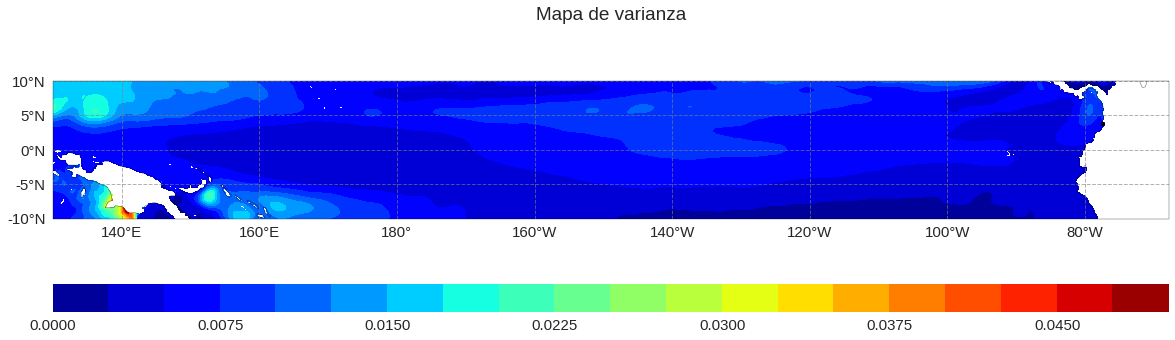

In [23]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title("Mapa de varianza",y=1.4,fontsize=19)
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,var,20,transform=ccrs.PlateCarree(),cmap="jet")
gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=180), draw_labels=False,
                  ylocs=np.array([-10,-5,0,5,10]),xlocs=np.array(np.arange(-60,140,20)),linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.add_geometries([ring], ccrs.PlateCarree(), facecolor="None", edgecolor='black',linewidth=2)
ax.coastlines()

ax.set_xticks(np.arange(-40, 120, 20))
ax.set_xticklabels(x_tick_labels)

ax.set_yticks(np.arange(-10, 11, 5))
ax.set_yticklabels(y_tick_labels)

cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

# Varianza en la banda

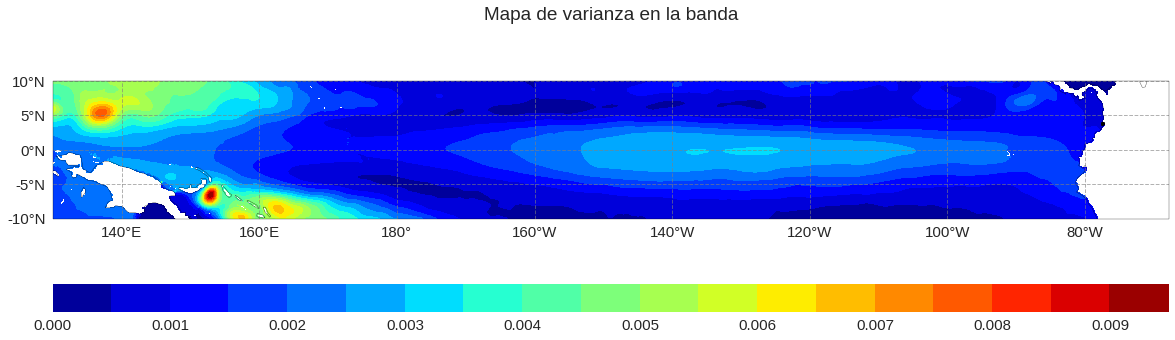

In [25]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title("Mapa de varianza en la banda",y=1.4,fontsize=19)
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,var_banda,20,transform=ccrs.PlateCarree(),cmap="jet")
gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=180), draw_labels=False,
                  ylocs=np.array([-10,-5,0,5,10]),xlocs=np.array(np.arange(-60,140,20)),linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.add_geometries([ring], ccrs.PlateCarree(), facecolor="None", edgecolor='black',linewidth=2)
ax.coastlines()


ax.set_xticks(np.arange(-40, 120, 20))
ax.set_xticklabels(x_tick_labels)


ax.set_yticks(np.arange(-10, 11, 5))
ax.set_yticklabels(y_tick_labels)

cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

# Porcentaje de varianza

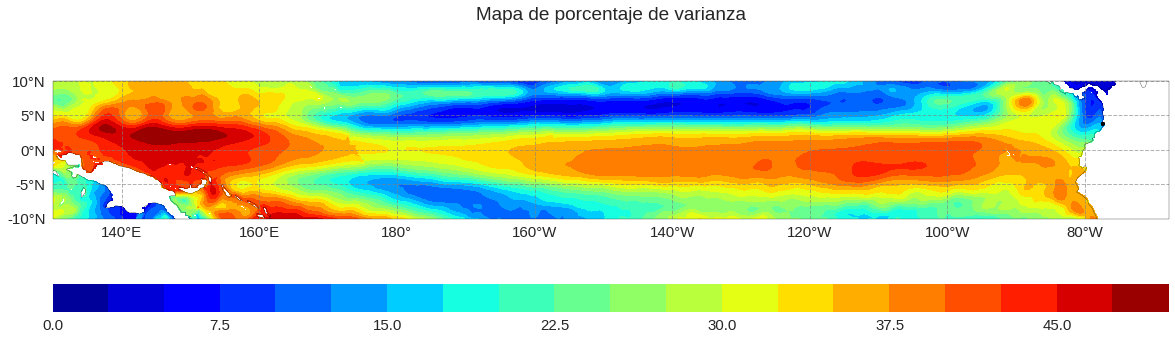

In [26]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title("Mapa de porcentaje de varianza",y=1.4,fontsize=19)
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,var_porcentaje,20,transform=ccrs.PlateCarree(),cmap="jet")

gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=180), draw_labels=False,
                  ylocs=np.array([-10,-5,0,5,10]),xlocs=np.array(np.arange(-60,140,20)),linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.add_geometries([ring], ccrs.PlateCarree(), facecolor="None", edgecolor='black',linewidth=2)
ax.coastlines()


ax.set_xticks(np.arange(-40, 120, 20))
ax.set_xticklabels(x_tick_labels)


ax.set_yticks(np.arange(-10, 11, 5))
ax.set_yticklabels(y_tick_labels)
cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

# Correlación de Pearson y Spearman

In [27]:
sp_ssh=corr(ssh_copy,4)
sp_t=corr(t,4)
sp_v=corr(vel_v,4)
sp_u=corr(vel_u,4)

Proceso terminado
Proceso terminado
Proceso terminado
Proceso terminado


In [29]:
def plot_corr(corr_variable,n_rez,name):
    for i in range(n_rez):
        fig=plt.figure(figsize=(20,20))
        ax=fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
        ax.set_title("Mapa de Correlación de "+name+"-Rezago+"+str(i),y=1.2,fontsize=19)
        x,y=np.meshgrid(lon,lat)
        cf=ax.contourf(x,y,corr_variable[i,:,:],20,transform=ccrs.PlateCarree(),cmap="jet")
        gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=180), draw_labels=False,
                      ylocs=np.array([-10,-5,0,5,10]),xlocs=np.array(np.arange(-60,140,20)),linewidth=1, color='gray', alpha=0.6, linestyle='--')
        gl.xlabel_style = {'size': 18, 'color': 'black'}
        gl.ylabel_style = {'size': 18, 'color': 'black'}
    #     ax.add_geometries([ring], ccrs.PlateCarree(), facecolor="None", edgecolor='black',linewidth=2)
        ax.coastlines()

        ax.set_xticks(np.arange(-40, 120, 20))
        ax.set_xticklabels(x_tick_labels)


    #     if i==1:
    #         ax.set_xlim((40,60))

        ax.set_yticks(np.arange(-10, 11, 5))
        ax.set_yticklabels(y_tick_labels)

        cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
        cbar.ax.tick_params(labelsize=15) 

        plt.show()

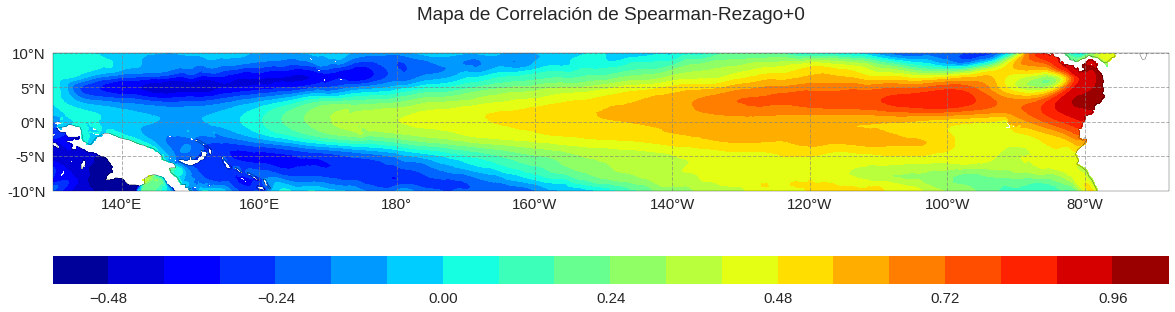

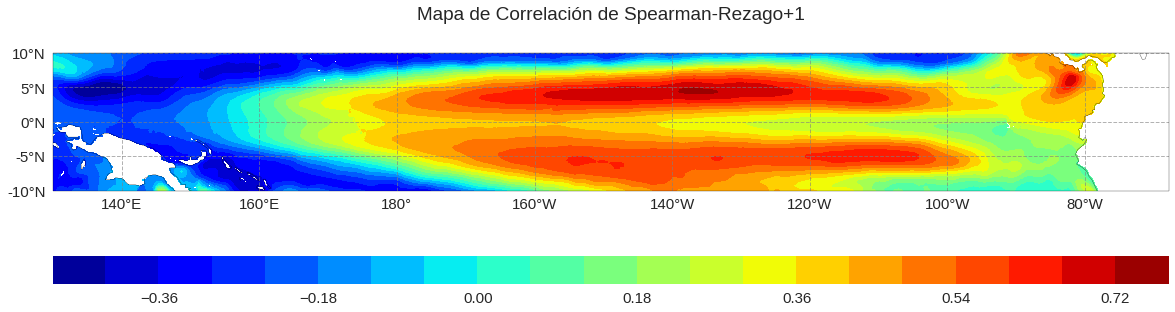

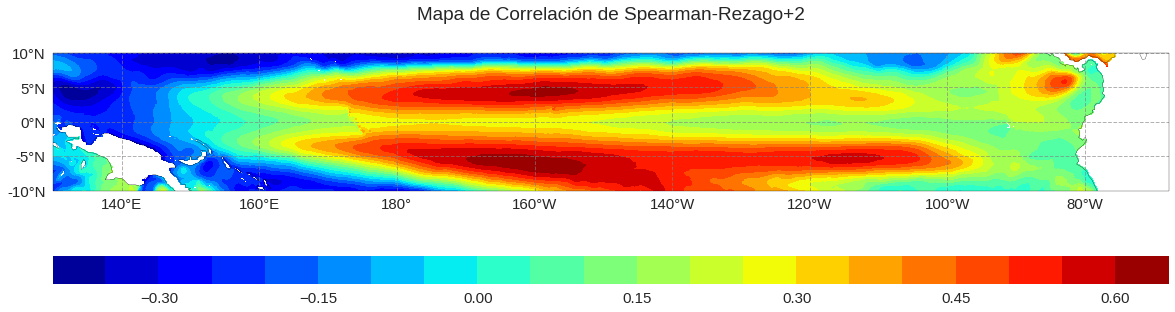

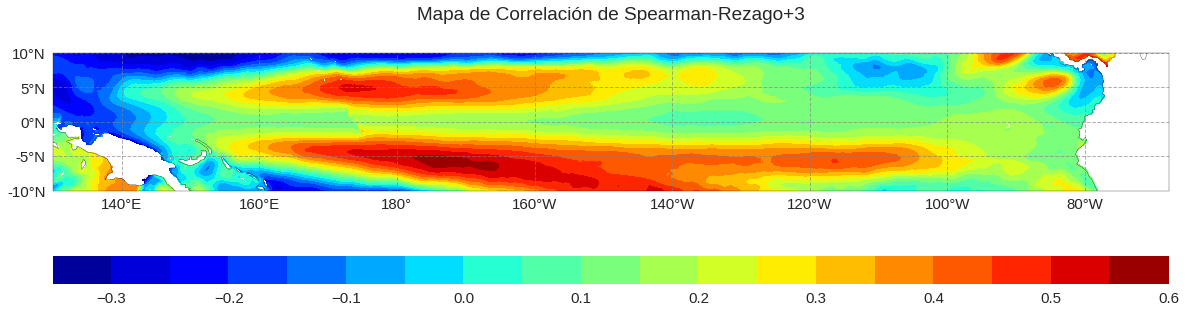

In [30]:
plot_corr(sp_ssh,4,"Spearman")

# Correlación con Temperatura

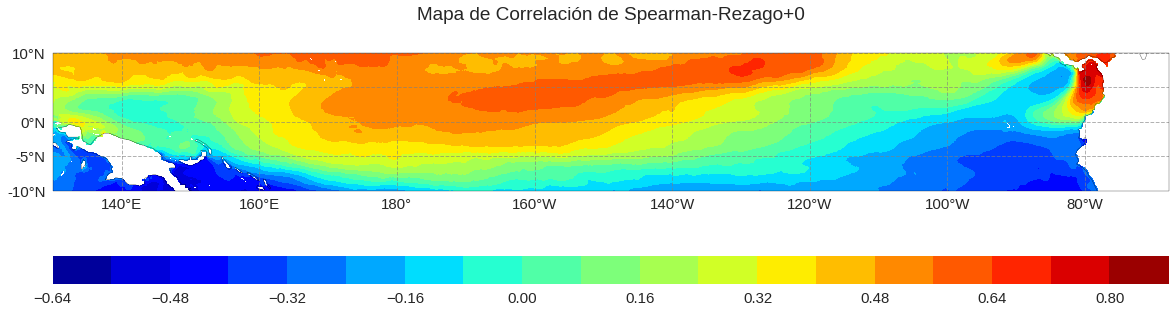

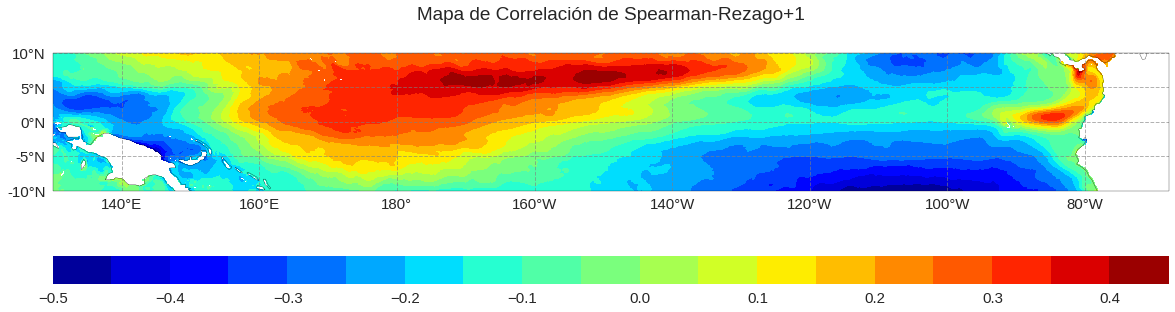

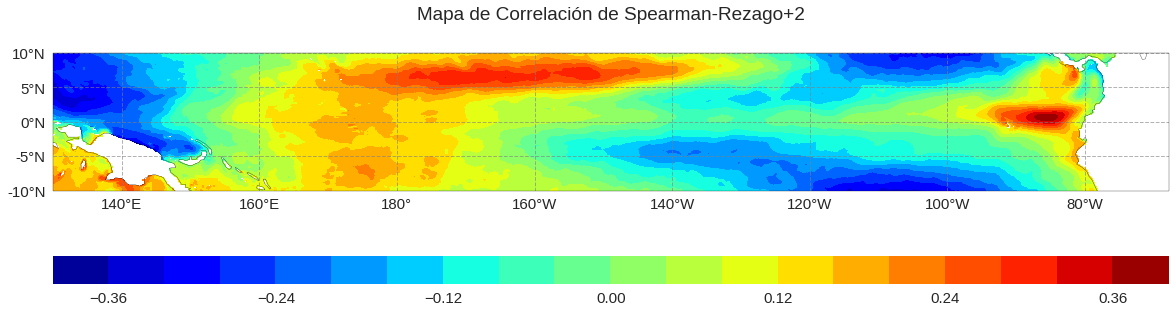

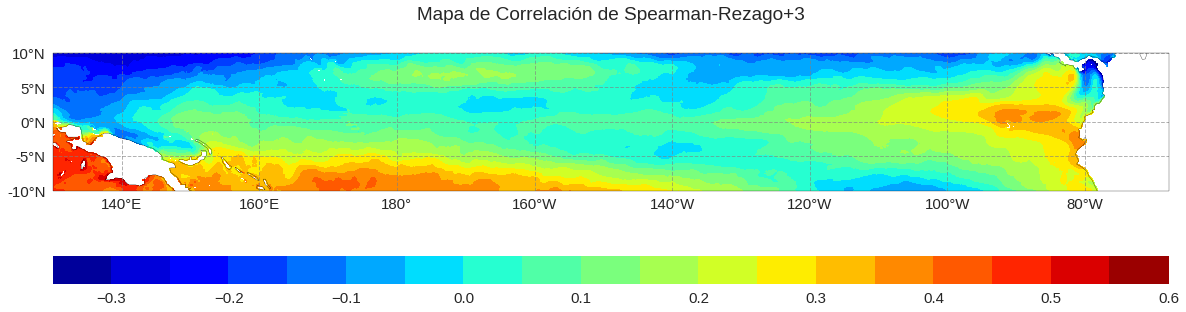

In [31]:
plot_corr(sp_t,4,"Spearman")

# Correlación con corrientes

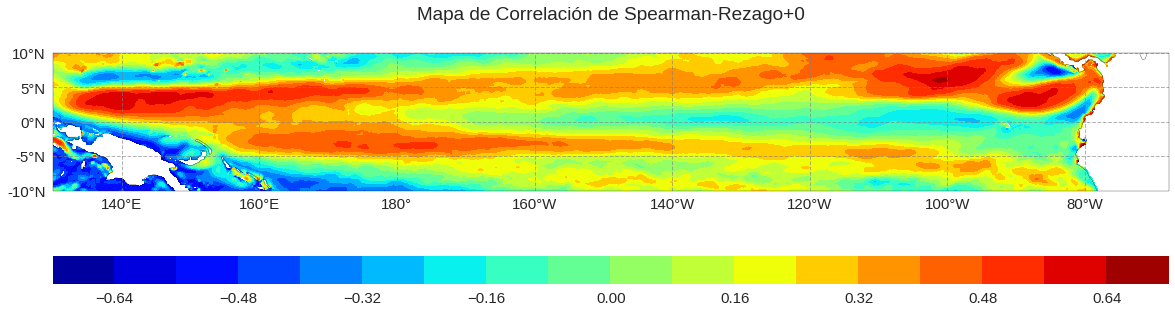

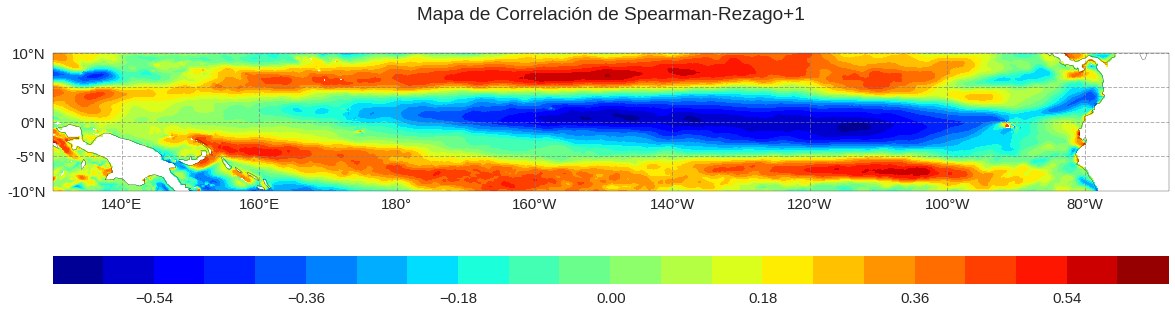

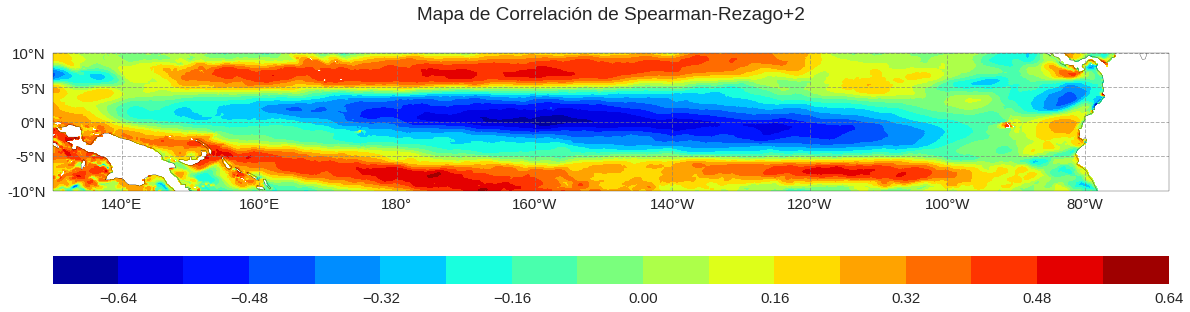

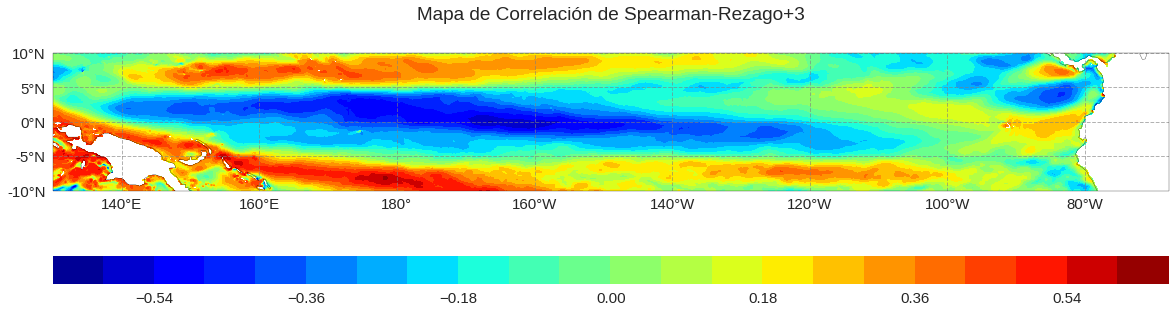

In [32]:
plot_corr(sp_u,4,"Spearman")

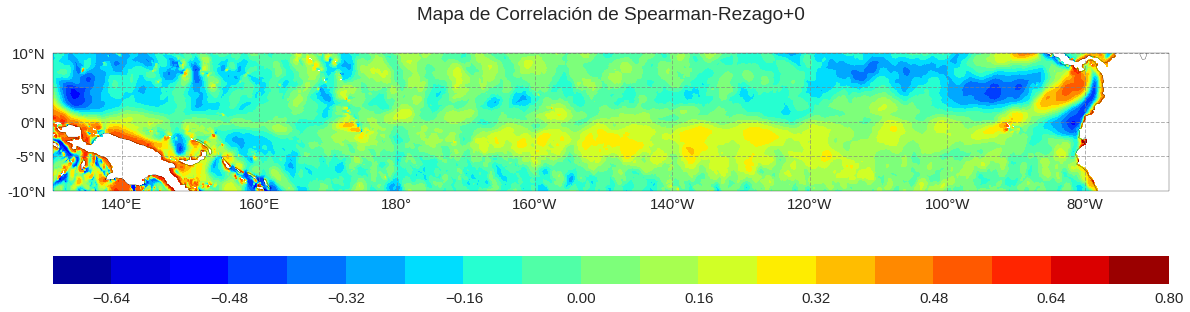

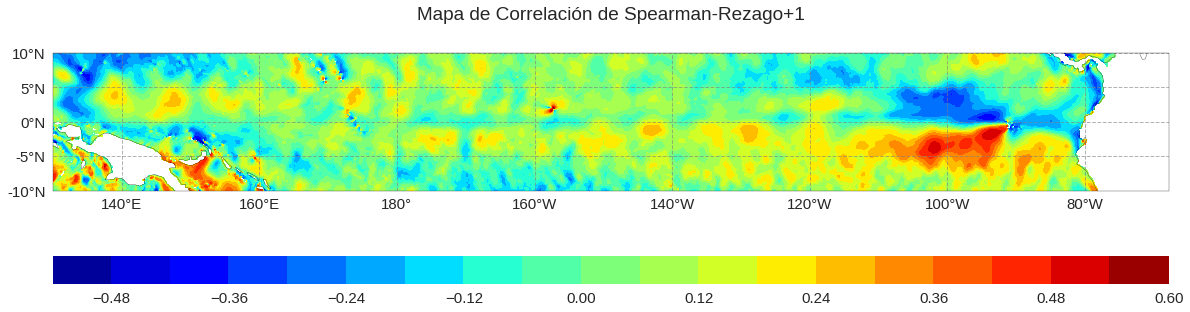

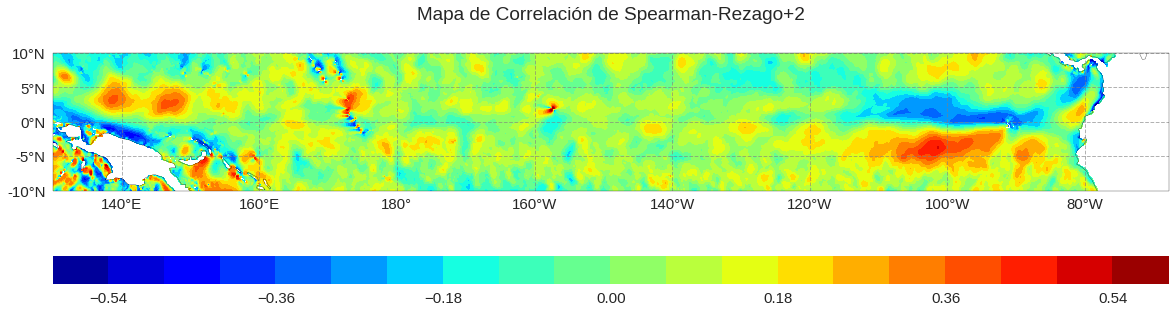

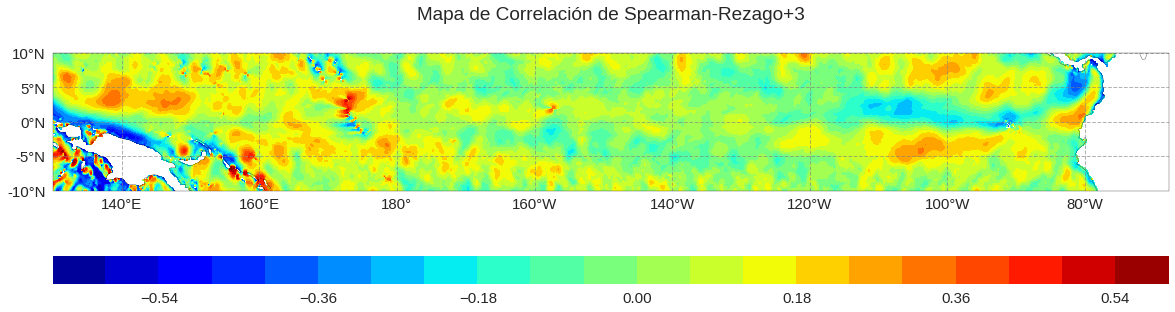

In [33]:
plot_corr(sp_v,4,"Spearman")

# Máximos para cada rezago

In [121]:
# n_rez=4
# for i in range(n_rez):
# #     region=spearman_rez[i,:,:]>=np.nanpercentile(spearman_rez[i,:,:],90)
#     region=((sp_v[i,:,:]>0.54) | (sp_v[i,:,:]<-0.54))
#     fig=plt.figure(figsize=(20,20))
#     ax=fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
#     ax.set_title("Mapa de Correlación de Spearman-Rezago+"+str(i),y=1.2,fontsize=19)
#     x,y=np.meshgrid(lon,lat)
    
#     cf=ax.contourf(x,y,region*sp_v[i,:,:],20,transform=ccrs.PlateCarree(),cmap="jet")
#     gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=180), draw_labels=False,
#                   ylocs=np.array([-10,-5,0,5,10]),xlocs=np.array(np.arange(-60,140,20)),linewidth=1, color='gray', alpha=0.6, linestyle='--')
#     gl.xlabel_style = {'size': 18, 'color': 'black'}
#     gl.ylabel_style = {'size': 18, 'color': 'black'}
#     ax.add_geometries([ring], ccrs.PlateCarree(), facecolor="None", edgecolor='black',linewidth=2)
#     ax.coastlines()


#     ax.set_xticks(np.arange(-40, 120, 20))
#     ax.set_xticklabels(x_tick_labels)


#     ax.set_yticks(np.arange(-10, 11, 5))
#     ax.set_yticklabels(y_tick_labels)

#     cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
#     cbar.ax.tick_params(labelsize=15) 

# #     plt.show()

# Eligiendo la región a monitorear para rezago 1

In [134]:
def mean_espacial(variable,lat_max,lat_min,lon_max,lon_min,corr,rezago):
    "Input: variable,lat_max,lat_min,lon_max,lon_min,corr,rezago"
    ind_lat = np.where((lat<=lat_max) & (lat>=lat_min))[0]
    ind_lon = np.where((lon<=(360+lon_max)) & (lon>=(360+lon_min)))[0]
    serie_lat=np.nanmean(variable[:,ind_lat],axis=1)
    ssh=np.nanmean(serie_lat[:,ind_lon],axis=1)
    
    lns = [lon_max, lon_max, lon_min, lon_min]
    lts = [lat_min, lat_max, lat_max,lat_min]
    ring = LinearRing(list(zip(lns, lts)))

    fig=plt.figure(figsize=(20,20))
    ax=fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
    x,y=np.meshgrid(lon,lat)
    cf=ax.contourf(x,y,corr[rezago,:,:],20,transform=ccrs.PlateCarree(),cmap="jet")
    # ct=ax.contour(x,y,ssh,20,transform=ccrs.PlateCarree(),colors='k')
    gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=180), draw_labels=False,
                      ylocs=np.array([-10,-5,0,5,10]),xlocs=np.array(np.arange(-60,140,20)),linewidth=1, color='gray', alpha=0.6, linestyle='--')
    gl.xlabel_style = {'size': 18, 'color': 'black'}
    gl.ylabel_style = {'size': 18, 'color': 'black'}
    ax.add_geometries([ring], ccrs.PlateCarree(), facecolor="None", edgecolor='black',linewidth=2)
    ax.coastlines(resolution='10m')

    ax.set_xticks(np.arange(-40, 120, 20))
    ax.set_xticklabels(x_tick_labels)

    ax.set_yticks(np.arange(-10, 11, 5))
    ax.set_yticklabels(y_tick_labels)

#     ax.set_xlim(180+lon_min+5,180+lon_max-5)
#     ax.set_ylim((lat_min-2,lat_max+2))

    cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
    cbar.ax.tick_params(labelsize=15) 

    plt.show()
    return ssh

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


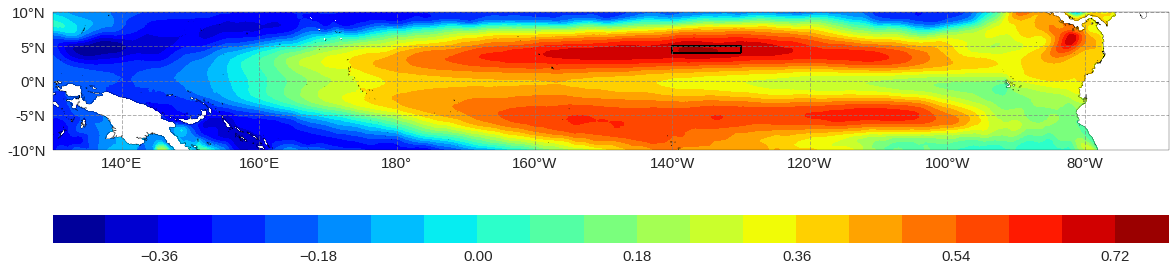

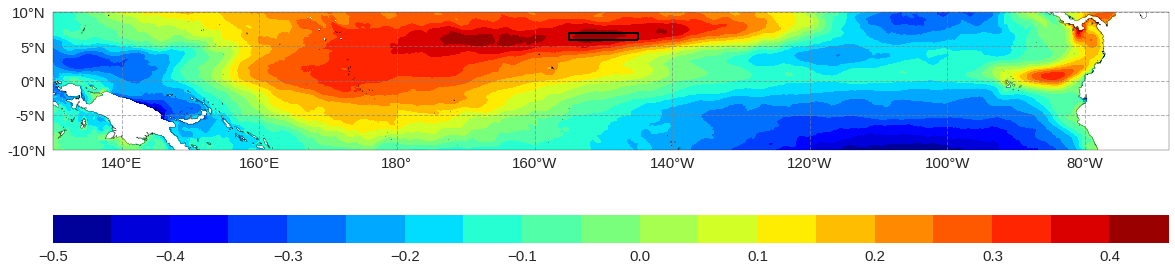

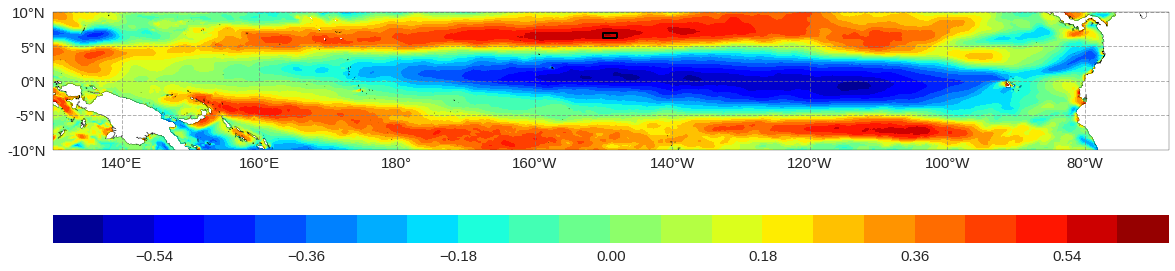

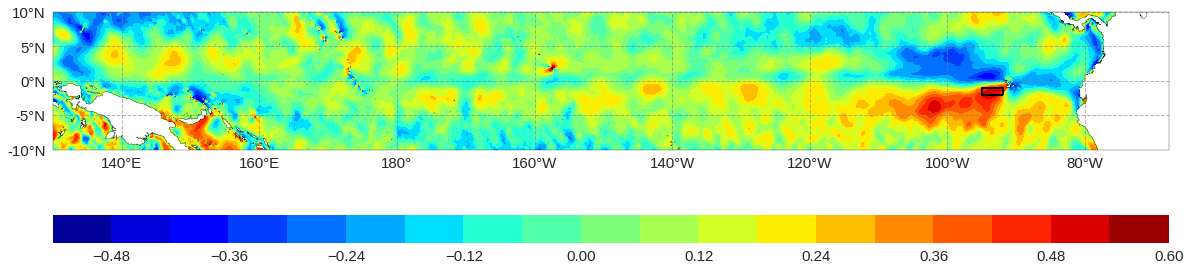

In [135]:
# nivel del mar
ssh_net=mean_espacial(ssh_copy,5.0,4.0,-130,-140,sp_ssh,1)

# temperatura
t_net=mean_espacial(t,7.0,6.0,-145,-155,sp_t,1)

# u
u_net=mean_espacial(vel_u,7.0,6.2,-148,-150,sp_u,1)

# v
v_net=mean_espacial(vel_v,-1,-2,-92,-95,sp_v,1)


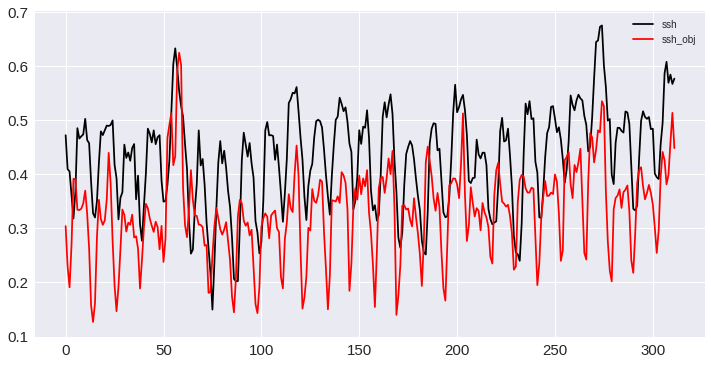

In [146]:
plt.figure(figsize=(12,6))
# plt.plot(u_net,label="u")
plt.plot(ssh_net,c='k',label="ssh")
plt.plot(serie_ssh,c='r',label="ssh_obj")
# plt.plot(v_net,label="v")
plt.legend()

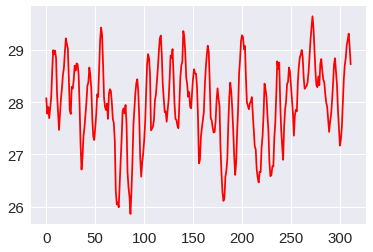

In [125]:
plt.plot(t_net,c='r')

In [141]:
input_net=pd.DataFrame({"ssh":ssh_net,"t":t_net,"u":u_net,"v":v_net,"ssh_obj":serie_ssh})
input_net

,ssh,t,u,v,ssh_obj
0,0.472543,28.079724,0.195267,-0.032063,0.304331
1,0.409803,27.780169,0.236106,0.030256,0.229540
2,0.405555,27.909916,0.167376,-0.066339,0.191005
3,0.361863,27.694136,-0.066096,-0.076999,0.268380
4,0.318402,27.885302,-0.138168,-0.068941,0.391837
...,...,...,...,...,...
307,0.608429,29.098388,0.697272,0.068262,0.381583
308,0.569632,29.194546,0.463906,0.109480,0.399406
309,0.584687,29.315145,0.493142,0.040474,0.459039
310,0.567434,29.045714,0.435514,0.057404,0.513972


In [142]:
input_net.to_csv("input_net_region1.csv")

# Eligiendo series en la región a monitorear para rezago 2

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


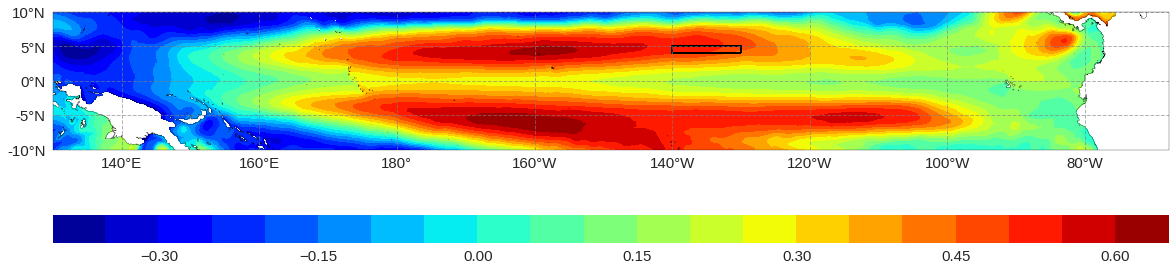

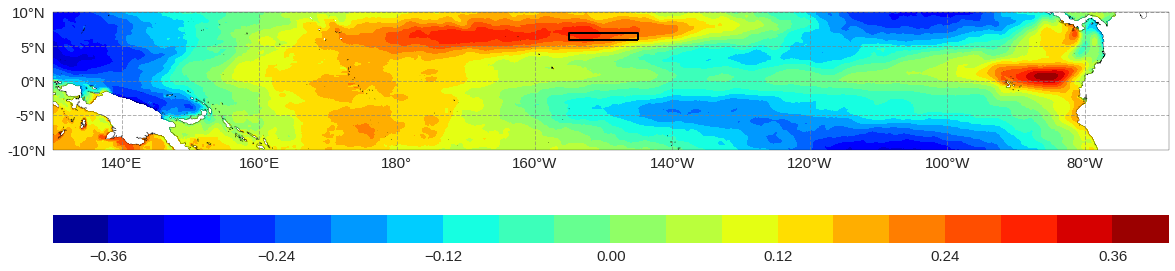

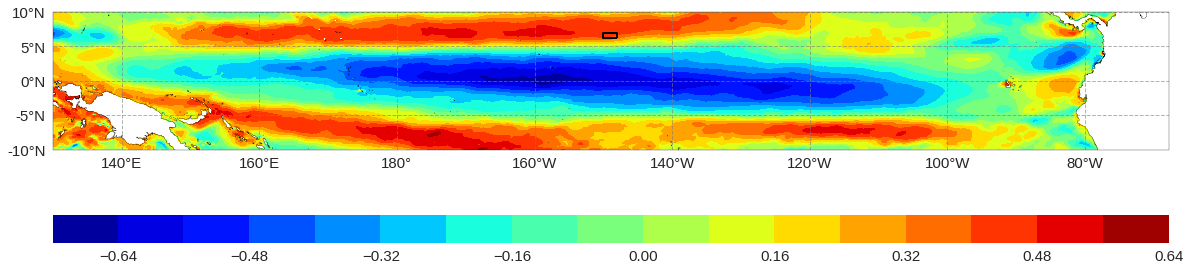

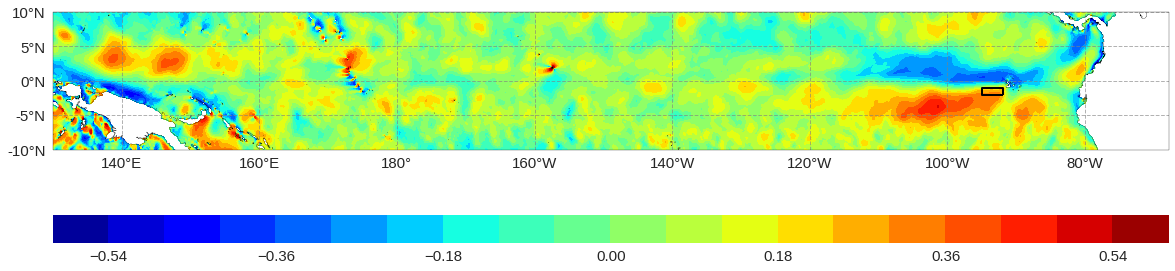

In [137]:
# nivel del mar
ssh_net2=mean_espacial(ssh_copy,5.0,4.0,-130,-140,sp_ssh,2)

# temperatura
t_net2=mean_espacial(t,7.0,6.0,-145,-155,sp_t,2)

# u
u_net2=mean_espacial(vel_u,7.0,6.2,-148,-150,sp_u,2)

# v
v_net2=mean_espacial(vel_v,-1,-2,-92,-95,sp_v,2)

In [ ]:
plt.plot(u_net,label="u")
plt.plot(ssh_net,c='k',label="ssh")
plt.plot(v_net,label="v")
plt.legend()

In [ ]:
plt.plot(t_net,c='r')

In [ ]:
input_net=pd.DataFrame({"ssh":ssh_net2,"t":t_net2,"u":u_net2,"v":v_net2})

In [ ]:
input_net.to_csv("input_net_region2.csv")

# Red Neuronal 

# Preguntas importantes

Tenemos dos preguntas de análisis:

\begin{enumerate}
    \item ¿Cuál es el efecto del ENSO en la variabilidad interanual del nivel del mar?
    \item Durante una fase cálida ¿existe una zona mar afuera que pueda servir para pronosticar el nivel del mar en regiones más costeras?
\end{enumerate}    

**1. Teniendo en cuenta que un objetivo es evaluar el efecto del ENSO en el nivel del mar**

Cómo evaluar dicho efecto más allá de:

1. realizar la EOF que permite conocer la estructura espacial y los modos de oscilación.
2. realizar gráficas de porcentajes de varianza
3. EOF Extendida

**2. Respecto al segundo gran objetivo hay muchas dudas sobre**


- ¿Cómo elegir la zona ya teniendo en cuenta los rezagos?

Ya se ha hecho:

1. Mapas de correlación con rezagos


